In [ ]:
"""
add to image_dataloader_config.py

"""

@dataclass
class DistortedNISTLoaderConfig:
    name:str = "DistortedNISTLoader"
    dataset_name:str = "mnist" # emnist, fashion, mnist
    batch_size: int= 23
    data_dir:str = image_data_path
    
    distortion: str = 'noise' # noise, swirl, pixelate, half_mask
    distortion_level: float = 0.4  # 0.4, 5, 0.7, None
    
    max_node_num: int = None
    max_feat_num: int = None

    dimensions: int = None
    vocab_size: int = 2
    unet_resize: bool = False

    pepper_threshold: float = 0.5
    flatten: bool = True
    as_image: bool = False

    max_training_size:int = None
    max_test_size:int = None

    total_data_size: int = None
    training_size: int = None
    test_size: int = None
    test_split: float = None

    temporal_net_expected_shape : List[int] = None
    data_min_max: List[float] = field(default_factory=lambda:[0.,1.])

    def __post_init__(self):
        self.dimensions, self.temporal_net_expected_shape = self.expected_shape(self.as_image,self.flatten,self.unet_resize)
        self.number_of_nodes = self.max_node_num
        self.number_of_labels = NUMBER_OF_LABELS[self.dataset_name]

    def expected_shape(self,as_image,flatten,unet=False):
        if as_image:
            if flatten:
                shape = [1,1,784]
                dimensions = 784
            else:
                if unet:
                    shape = [1, 32, 32]
                    dimensions = 1024
                else:
                    shape = [1, 28, 28]
                    dimensions = 784
        else:
            if flatten:
                shape = [784]
                dimensions = 784
            else:
                shape = [28,28]
                dimensions = 784
        return dimensions, shape

In [3]:

'''
Add this to 'image_dataloaders.py'
'''


import torch
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
from conditional_rate_matching.data.transforms import SqueezeTransform
from conditional_rate_matching.data.transforms import FlattenTransform
from conditional_rate_matching.data.image_dataloader_config import DistortedNISTLoaderConfig
from torch.utils.data import DataLoader, Dataset, TensorDataset
from skimage.transform import swirl


def get_conditional_data(config: DistortedNISTLoaderConfig):
    data_= config.dataset_name
    threshold = config.pepper_threshold
    dataloader_data_dir = config.data_dir
    distortion = config.distortion
    distortion_level = config.distortion_level

    #...binerize MNIST images for dataset 1:

    transformation_list = [transforms.ToTensor(), transforms.Lambda(lambda x: (x > threshold).float())]

    #...define 1-parametric distortions for dataset 0:

    distortion_list=[]
    
    if distortion == 'noise': 
        distortion_list.append(transforms.ToTensor())
        distortion_list.append(transforms.Lambda(lambda x: add_gaussian_noise(x, std=distortion_level)))
    
    elif distortion == 'swirl': 
        distortion_list.append(transforms.Lambda(lambda x: apply_swirl(x, strength=distortion_level)))
        distortion_list.append(transforms.ToTensor())

    elif distortion == 'pixelate': 
        distortion_list.append(transforms.Lambda(lambda x: apply_coarse_grain(x, p=distortion_level)))
        distortion_list.append(transforms.ToTensor())

    elif distortion == 'half_mask':
        distortion_list.append(transforms.Lambda(lambda x: apply_half_mask(x)))
        distortion_list.append(transforms.ToTensor())

    elif distortion == 'half_noise':
        distortion_list.append(transforms.Lambda(lambda x: apply_half_noise(x, std=distortion_level)))
        distortion_list.append(transforms.ToTensor())

    distortion_list.append(transforms.Lambda(lambda x: (x > threshold).float()))

    #...reshape images accordingly:

    if config.flatten:
        transformation_list.append(FlattenTransform)
        distortion_list.append(FlattenTransform)

    if not config.as_image:
        transformation_list.append(SqueezeTransform)
        distortion_list.append(SqueezeTransform)

    if config.unet_resize:
        transformation_list.append(transforms.Resize((32, 32)))
        distortion_list.append(transforms.Resize((32, 32)))

    #...compose relevant transformations:
        
    distort = transforms.Compose(distortion_list)
    transform = transforms.Compose(transformation_list)

    # Load MNIST dataset

    if data_ == "mnist":
        train_data_0 = datasets.MNIST(dataloader_data_dir, train=True, download=True, transform=distort)
        test_data_0 = datasets.MNIST(dataloader_data_dir, train=False, download=True, transform=distort)
        train_data_1 = datasets.MNIST(dataloader_data_dir, train=True, download=True, transform=transform)
        test_data_1 = datasets.MNIST(dataloader_data_dir, train=False, download=True, transform=transform)
    else:
        raise Exception("Distortions only implemented for 'mnist' dataset!")

    return (train_data_0, test_data_0), (train_data_1, test_data_1)


class DistortedNISTLoaderDataEdge:
    def __init__(self, test_dl, train_dl):
        self.test_dl = test_dl
        self.train_dl = train_dl

    def train(self):
        return self.train_dl

    def test(self):
        return self.test_dl


class CoupledNISTDataset(Dataset):
    def __init__(self, dataset_0, dataset_1):
        self.dataset_0 = dataset_0
        self.dataset_1 = dataset_1

    def __len__(self):
        return min(len(self.dataset_0), len(self.dataset_1))

    def __getitem__(self, idx):
        img_0, _ = self.dataset_0[idx]
        img_1, _ = self.dataset_1[idx]
        return img_0, img_1 

class DistortedNISTLoader:
    config: DistortedNISTLoaderConfig
    name: str = "DistortedNISTDataloader"

    def __init__(self, config: DistortedNISTLoaderConfig):
        """
        :param config:
        :param device:
        """
        self.config = config
        self.number_of_spins = self.config.dimensions
        data_0, data_1 = get_conditional_data(self.config)
        self.create_conditional_dataloaders(data_1, data_0)

    def train(self):
        return self.train_conditional()

    def test(self):
        return self.test_conditional()

    def train_conditional(self):
        for databatch in self.data_train:
            yield [databatch[0]],[databatch[1]]

    def test_conditional(self):
        for databatch in self.data_test:
            yield [databatch[0]],[databatch[1]]

    def define_sample_sizes(self):
        self.training_data_size = self.config.training_size
        self.test_data_size = self.config.test_size
        self.total_data_size = self.training_data_size + self.test_data_size
        self.config.training_proportion = float(self.training_data_size) / self.total_data_size

    def create_conditional_dataloaders(self, data_1, data_0):
        train_data_0, test_data_0 = data_0
        train_data_1, test_data_1 = data_1

        #=======================
        # INDEPENDENT
        #=======================

        self.data0_train = DataLoader(train_data_0, batch_size=self.config.batch_size, shuffle=True)
        self.data1_train = DataLoader(train_data_1, batch_size=self.config.batch_size, shuffle=True)
        self.data0_test = DataLoader(test_data_0, batch_size=self.config.batch_size, shuffle=True)
        self.data1_test = DataLoader(test_data_1, batch_size=self.config.batch_size, shuffle=True)
        self.data1 = DistortedNISTLoaderDataEdge(self.data1_test, self.data1_train)
        self.data0 = DistortedNISTLoaderDataEdge(self.data0_test, self.data0_train)

        #=======================
        # COUPLED
        #=======================

        train_ds = CoupledNISTDataset(train_data_0, train_data_1)
        test_ds = CoupledNISTDataset(test_data_0, test_data_1)
        self.data_train = DataLoader(train_ds, batch_size=self.config.batch_size, shuffle=True)
        self.data_test = DataLoader(test_ds, batch_size=self.config.batch_size, shuffle=False)

#...type of MNIST distortions

def add_gaussian_noise(tensor, mean=0., std=0.4):
    """Adds Gaussian noise to a tensor."""
    noise = torch.randn(tensor.size()) * std + mean
    return tensor + noise

def apply_swirl(image, strength=5, radius=20):
    """Apply swirl distortion to an image."""
    image_np = np.array(image)
    swirled_image = swirl(image_np, strength=strength, radius=radius, mode='reflect')
    return Image.fromarray(swirled_image)

def apply_coarse_grain(image, p=0.7):
    """Coarse grains an image to a lower resolution."""
    old_size = image.size
    if p <= 0: return image  
    elif p >= 1: return Image.new('L', image.size, color=0)  # Return a black image
    new_size = max(1, int(image.width * (1 - p))), max(1, int(image.height * (1 - p)))
    image = image.resize(new_size, Image.BILINEAR)
    return image.resize(old_size, Image.NEAREST)  # Resize back to 28x28

def apply_half_mask(image):
    """ Masks the first half of the image along its width. """
    mask_height = int(image.height / 2)
    mask_width = image.width
    mask_size = (mask_width, mask_height)
    mask = Image.new('L', mask_size, color=255) 
    black_img = Image.new('L', image.size, color=0)
    black_img.paste(mask, (0, 0))  
    return Image.composite(image, black_img, black_img)

def apply_half_noise(image, std=1):
    """ Masks the first half of the image along its width. """
    mask_height = int(image.height / 2)
    mask_width = image.width
    mask_size = (mask_width, mask_height)
    mask = Image.new('L', mask_size, color=255) 
    black_img = Image.new('L', image.size, color=0)
    black_img.paste(mask, (0, 0))  
    return Image.composite(image, black_img, black_img)


/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/tqdm-4.66.1-py3.10.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# validation

In [4]:
import matplotlib.pyplot as plt

def plot_images(images, figsize=(4, 4), cmap=None):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0)
        # img = img.squeeze()  # Squeeze the last dimension if it's 1
        if cmap is not None: ax.imshow(img, cmap=cmap)
        else: ax.imshow(img)
        ax.axis('off')
    plt.show()

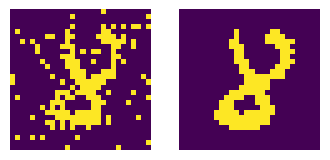

In [5]:
from conditional_rate_matching.data.image_dataloader_config import DistortedNISTLoaderConfig

data_config = DistortedNISTLoaderConfig(flatten=False, batch_size=1)
data_config.distortion = 'noise'
data_config.distortion_level = 0.4
dataloder = DistortedNISTLoader(data_config)
img = next(dataloder.data_train.__iter__())
plot_images(img)


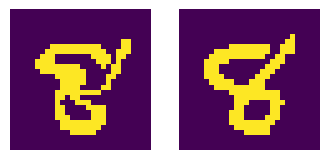

In [5]:
data_config = DistortedNISTLoaderConfig(flatten=False, batch_size=1)
data_config.distortion = 'swirl'
data_config.distortion_level = -4
dataloder = DistortedNISTLoader(data_config)
img = next(dataloder.data_train.__iter__())
plot_images(img)

/tmp/ipykernel_1809047/2783328872.py:188: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize(new_size, Image.BILINEAR)
/tmp/ipykernel_1809047/2783328872.py:189: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  return image.resize(old_size, Image.NEAREST)  # Resize back to 28x28


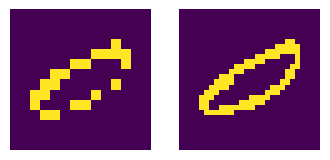

In [6]:
data_config = DistortedNISTLoaderConfig(flatten=False, batch_size=1)
data_config.distortion = 'pixelate'
data_config.distortion_level = 0.5
dataloder = DistortedNISTLoader(data_config)
img = next(dataloder.data_train.__iter__())
plot_images(img)

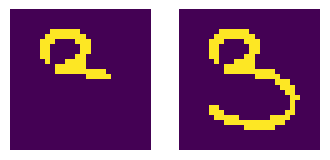

In [7]:
data_config = DistortedNISTLoaderConfig(flatten=False, batch_size=1)
data_config.distortion = 'half_mask'
data_config.distortion_level = 1
dataloder = DistortedNISTLoader(data_config)
img = next(dataloder.data_train.__iter__())
plot_images(img)